# Conditional Volatility

_UNDER CONSTRUCTION_


- Value at Risk, Expected Shortfall, GARCH, EWMA
- Cryptos: bitcoin, etherium
- Historical VaR, ES
- pof, LR: Theoretical ES, VaR - normal, t(6)
- ARCH, GARCH, EWMA
- Copulas
- Power Laws, EVT
- Bootstrapping with circular block


In [1]:
import numpy as np
from scipy.stats import chi2, norm, t, jarque_bera, kurtosis, skew
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns 
from finds.readers import Alfred
from finds.finance import kupiecLR, pof, halflife, RiskMeasure
from finds.misc import Show
from secret import credentials, paths
show = Show(ndigits=4, latex=None)
pd.set_option('display.max_rows', None)
VERBOSE = 0
#%matplotlib qt
imgdir = paths['images'] / 'ts'

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

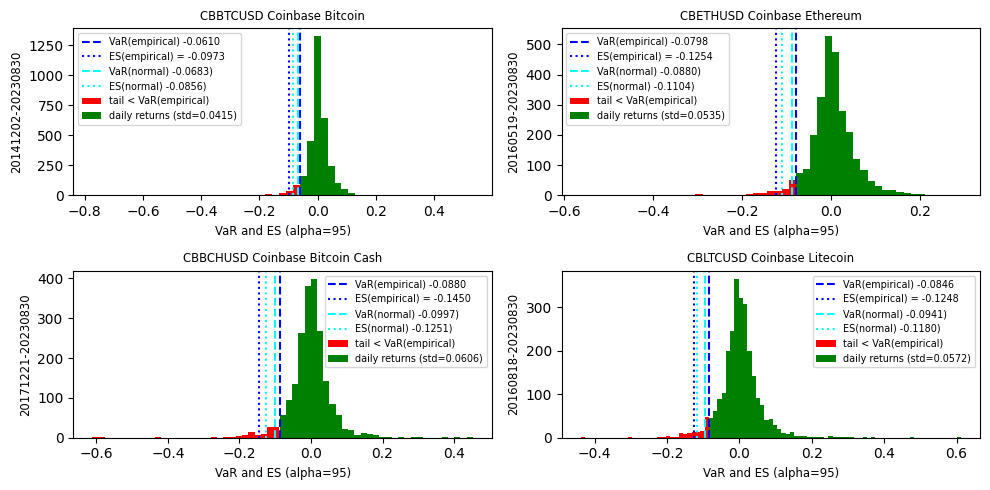

In [3]:
## Histogram, VaR and ES of Cryptocurrencies
labels = ['CBBTCUSD', 'CBETHUSD', 'CBBCHUSD', 'CBLTCUSD']
alpha = 0.95   # VaR parameter
out = {}
fig, axes = plt.subplots(2, 2, num=1, clear=True, figsize=(10, 5))
for label, ax in zip(labels, list(axes.ravel())):
    rets = alf(label, log=1, diff=1).dropna()
    sigma = rets.std()
    risk_measure = RiskMeasure(rets, alpha=0.95)
    var = risk_measure.value_at_risk()
    es = risk_measure.expected_shortfall()
    var_normal = risk_measure.value_at_risk(normal=True)
    es_normal = risk_measure.expected_shortfall(normal=True)
    
    n, bins, _ = ax.hist(rets[rets < var], color='red', bins=30)
    stepsize = (bins[-1] - bins[0]) / (len(bins) - 1)
    bins = np.arange(var, max(rets) + stepsize, stepsize)
    ax.hist(rets[rets >= var], color='green', bins=bins)

    ax.axvline(var, color='blue', ls='--')
    ax.axvline(es, color='blue', ls=':')
    ax.axvline(var_normal, color='cyan', ls='--')
    ax.axvline(es_normal, color='cyan', ls=':')
    ax.legend([f'VaR(empirical) {var:.4f}',
               f'ES(empirical) = {es:.4f}',
               f'VaR(normal) {var_normal:.4f})',
               f'ES(normal) {es_normal:.4f})',
               'tail < VaR(empirical)',
               f'daily returns (std={sigma:.4f})'], fontsize='x-small')
    ax.set_title(f"{label} {alf.header(label)[:60]}",
                 {'fontsize' : 'small'})
    ax.set_ylabel(f'{min(rets.index)}-{max(rets.index)}',
                  fontsize='small')
    ax.set_xlabel(f'VaR and ES (alpha={alpha*100:.0f})',
                  fontsize='small')
    out[label] = {'std dev': np.std(rets, ddof=1),
                  'skewness': skew(rets),
                  'excess kurtosis': kurtosis(rets)-3,
                  'jarque-bera pvalue': jarque_bera(rets)[1]}
plt.tight_layout()
plt.savefig(imgdir / 'es.jpg')

In [4]:
# Non-normal: Jacque-Bera, excess kurtosis, mixtures
show(DataFrame(out).T)

,std dev,skewness,excess kurtosis,jarque-bera pvalue
CBBTCUSD,0.0415,-1.8691,50.6324,0.0
CBETHUSD,0.0535,-0.4478,5.3968,0.0
CBBCHUSD,0.0606,-0.4462,12.0454,0.0
CBLTCUSD,0.0572,0.7669,9.8600,0.0


## GARCH

In [5]:
## GARCH(1,1) wrapper around rugarch
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.misc import PyR
def rugarch(rets: Series, savefig: str = '') -> np.array:
    rugarch_ro = importr('rugarch')  # to use library rugarch
    c_ = ro.r['c']
    list_ = ro.r['list']
    spec = ro.r['ugarchspec'](mean_model=list_(armaOrder=c_(0, 0),
                                               include_mean=False))
    model = ro.r['ugarchfit'](spec, data=PyR(rets.values).ro) 
    ro.r['show'](model)

    if savefig:
        for which in [4, 5, 10, 11]:
            ro.r['plot'](model, which=which)
            PyR.savefig(imgdir / f'{savefig}{which}.png')
    return PyR(ro.r['sigma'](model)).values  # fitted volatility values

In [6]:
## Retrive Bitcoin from FRED and plot GARCH, EWMA and Daily Returns
series_id = 'CBBTCUSD'
X = alf(series_id, log=1, diff=1).dropna()
X.index = pd.DatetimeIndex(X.index.astype(str), freq='infer')
Y = np.square(X)

In [7]:
lam = 0.97
asset = np.sqrt((Y.ewm(alpha=1 - lam).mean()).rename('EWMA')).to_frame()
asset['EWMA(0.94)'] = np.sqrt((Y.ewm(alpha=1 - 0.94).mean()))
asset['GARCH'] = rugarch(X)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002039    0.000547    3.725 0.000195
omega   0.000082    0.000011    7.299 0.000000
alpha1  0.194184    0.017569   11.053 0.000000
beta1   0.785250    0.015994   49.096 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002039    0.000604   3.3742 0.000740
omega   0.000082    0.000031   2.6541 0.007952
alpha1  0.194184    0.060987   3.1840 0.001453
beta1   0.785250    0.045039  17.4349 0.000000

LogLikelihood : 6038.942 

Information Criteria
------------------------------------
                    
Akaike       -3.8208
Bayes        -3.8131
Shibata      -3.8208
Hannan-Quinn -3.8180

Weig

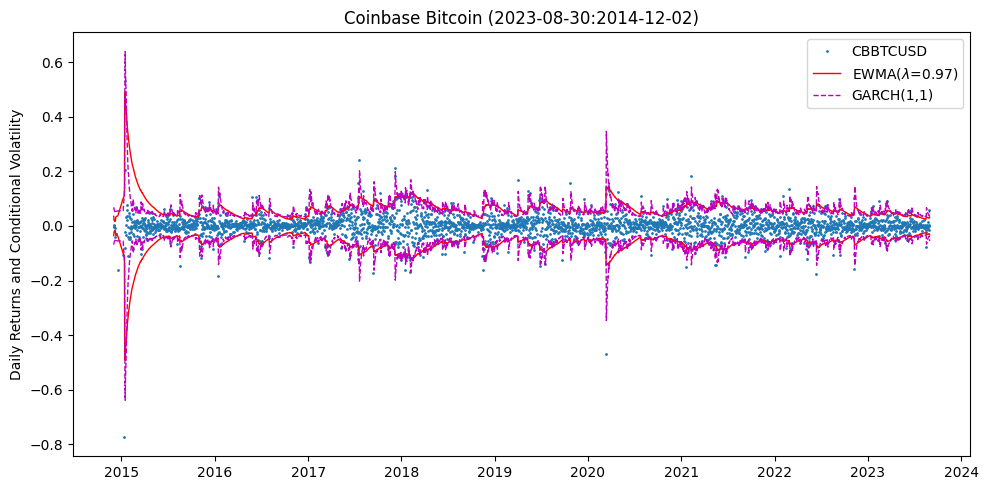

In [8]:
# Conditional Volatility Models EWMA(94), EWMA(97), GARCH(1, 1): Bitcoin
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
ax.plot(X.shift(-1), ls='', marker='.', markersize=2)
ax.plot(norm.ppf(1 - alpha) * asset['EWMA'], lw=1, ls='-', c='r')
ax.plot(norm.ppf(1 - alpha) * asset['GARCH'], lw=1, ls='--', c='m')
ax.set_title(alf.header(series_id)
             + f" ({max(Y.index).strftime('%Y-%m-%d')}:"
             + f"{min(Y.index).strftime('%Y-%m-%d')})")
ax.set_ylabel('Daily Returns and Conditional Volatility')
ax.legend([series_id] + [f"EWMA($\lambda$={lam:.2f})"] + ['GARCH(1,1)'])
ax.plot(-norm.ppf(1 - alpha) * asset['EWMA'], lw=1, ls='-', c='r')
ax.plot(-norm.ppf(1 - alpha) * asset['GARCH'], lw=1, ls='--', c='m')
plt.tight_layout()
plt.savefig(imgdir / 'ewma.jpg')

#  Value at Risk

In [9]:
# Statistical summary of conditional volatility models
y = X.shift(-1)
results = {}
for label, x in zip([series_id, 'EWMA(0.94)', f'EWMA({lam:.2f})','GARCH(1,1)'],
                    [1.0, asset['EWMA(0.94)'], asset['EWMA'], asset['GARCH']]):
    if isinstance(x, (int, float)):
        pof_ = pof((y / np.std(y))[126:], x)  # skip first six months
    else: 
        pof_ = pof(y[126:], x[126:])  # skip first six months
    results[label] = {'std dev': np.std(y.div(x).dropna()),
                      'skewness': skew(y.div(x).dropna()),
                      'excess kurtosis': kurtosis(y.div(x).dropna()) - 3,
                      f'pof({int(100*alpha)})': pof_['s']/pof_['n'],
                      'pof p-value': pof_['pvalue']}
show(DataFrame.from_dict(results, orient='index'), caption=series_id)

,std dev,skewness,excess kurtosis,pof(95),pof p-value
CBBTCUSD,,,,,
CBBTCUSD,0.0415,-1.8686,50.6217,0.0349,0.0001
EWMA(0.94),1.1386,-1.0813,15.4336,0.0462,0.3257
EWMA(0.97),1.0772,-1.4521,17.8767,0.0425,0.0530
"GARCH(1,1)",1.0249,-0.7791,8.6911,0.0415,0.0279
